In [1]:
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
import os

[2023-06-07 19:46:52] WARNING - __init__.py - scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [18]:
all_datasets = glob(r'C:\Project\datasets\helmet_dataset2\images\*')

In [19]:
len(all_datasets)

30237

In [20]:
train_images, valid_images = train_test_split(all_datasets, test_size=0.2, random_state=42)

In [21]:
len(valid_images)

6048

In [ ]:
for image in train_images:
    label = image.replace('\\images\\', '\\labels\\')
    image_name = image.split('\\')[-1]
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label, _ = os.path.splitext(label)
    label = label + '.txt'
    if not os.path.exists(r'C:\Project\datasets\helmet_dataset\train\images'):
        os.makedirs(r'C:\Project\datasets\helmet_dataset\train\images')
    if not os.path.exists(r'C:\Project\datasets\helmet_dataset\train\labels'):
        os.makedirs(r'C:\Project\datasets\helmet_dataset\train\labels')

    shutil.copy(image, r'C:\Project\datasets\helmet_dataset\train\images\{}'.format(image_name))
    shutil.copy(label, r'C:\Project\datasets\helmet_dataset\train\labels\{}'.format(label_name))

In [ ]:
for image in valid_images:
    label = image.replace('\\images\\', '\\labels\\')
    image_name = image.split('\\')[-1]
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label, _ = os.path.splitext(label)
    label = label + '.txt'

    if not os.path.exists(r'C:\Project\datasets\helmet_dataset\valid\images'):
        os.makedirs(r'C:\Project\datasets\helmet_dataset\valid\images')
    if not os.path.exists(r'C:\Project\datasets\helmet_dataset\valid\labels'):
        os.makedirs(r'C:\Project\datasets\helmet_dataset\valid\labels')

    shutil.copy(image, r'C:\Project\datasets\helmet_dataset\valid\images\{}'.format(image_name))
    shutil.copy(label, r'C:\Project\datasets\helmet_dataset\valid\labels\{}'.format(label_name))

In [17]:
trainer = Trainer(experiment_name='helmet_yolo_nas', ckpt_root_dir='checkpoints')

In [18]:
classes: ['head', 'helmet']
EPOCHS = 50

In [8]:
train_dataset = coco_detection_yolo_format_train(dataset_params={
    'data_dir': r'C:\Project\datasets\helmet_dataset\train', 'images_dir': 'images', 'labels_dir': 'labels'
    , 'classes': classes
}, dataloader_params={
    'batch_size': 4, 'num_workers': 2
})

Caching annotations: 100%|█████████▉| 4000/4001 [00:30<00:00, 139.93it/s]

In [9]:
valid_dataset = coco_detection_yolo_format_val(dataset_params={
    'data_dir': r'C:\Project\datasets\helmet_dataset\valid', 'images_dir': 'images', 'labels_dir': 'labels'
    , 'classes': classes
}, dataloader_params={
    'batch_size': 4, 'num_workers': 2
})

Caching annotations:  96%|█████████▋| 963/999 [00:09<00:00, 136.98it/s]

Caching annotations: 100%|██████████| 999/999 [00:09<00:00, 106.64it/s]


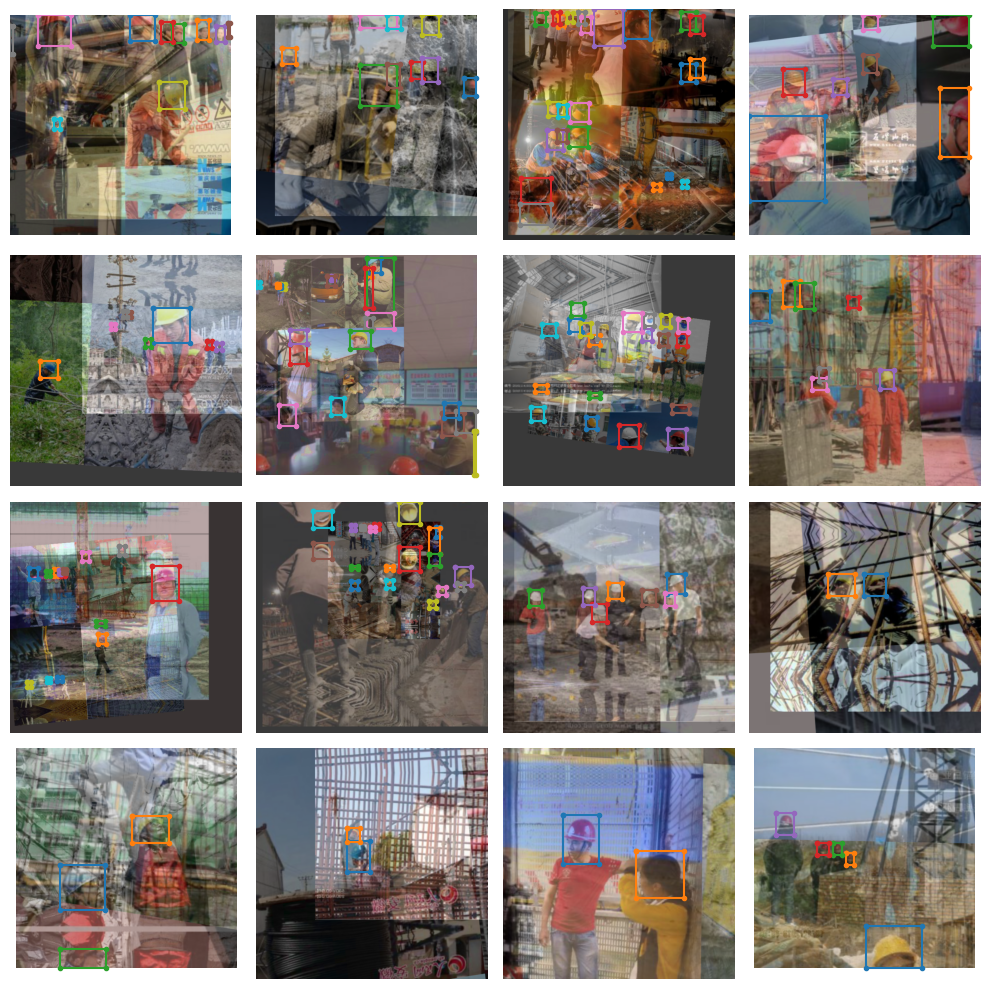

In [10]:
train_dataset.dataset.plot()

In [15]:
train_dataset.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [12]:
model = models.get('yolo_nas_m', num_classes=2, pretrained_weights='')

In [13]:
from super_gradients.training.metrics import DetectionMetrics_050_095

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(classes),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(classes),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(classes),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [14]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataset, valid_loader=valid_dataset)

Validation epoch 50: 100%|██████████| 250/250 [00:53<00:00,  4.70it/s]
